In [34]:
import tensorflow as tf
from glob import glob
from typing import List,Tuple
from data_loader import dataset_loader
from matplotlib import pyplot as plt
import numpy as np
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.3.0
Num GPUs Available:  8


In [35]:
dataset_dir='/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records'
ds_loader = dataset_loader(tfrec_dir=dataset_dir,batch_size=32)
ds_train,ds_valid,ds_test= ds_loader.build_dataset()

Number of records, Train files:408, validation files:88, Test Files:87
Building Dataset.......

((TensorSpec(shape=(None, 1536, 1536), dtype=tf.int8, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None))


In [41]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow tensor
    :param y_p red: TensorFlow tensor of the same shape as y_true
    :return: float
    """
    #original euclidean distance loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    #loss = K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))
    loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return loss


#(example["grid_map"],example["grid_org_res"],example["left_bnd"],example["right_bnd"],example#["car_odo"],example["init_path"])

def nn():

    # Grid Map input
    ip_gridmap = layers.Input(shape=(1536,1536,1))

    #CNN - branch1
    #1x1 conv 
    #x_A = layers.Conv2D(3,kernel_size=1,strides=1)(ip_gridmap)
    
    x_A = layers.Conv2D(16,kernel_size=7,strides=2)(ip_gridmap)
    x_A = layers.ReLU()(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    x_A = layers.Conv2D(32,kernel_size=5,strides=2)(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    
    x_A = layers.Conv2D(64,kernel_size=3,strides=2)(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(2,2))(x_A)


    x_A = layers.Flatten()(x_A)


    # Other inputs
    ip_grid_org_res = layers.Input(shape=(3,))
    ip_left_bnd = layers.Input(shape=(25,2))
    ip_right_bnd = layers.Input(shape=(25,2))
    ip_car_odo = layers.Input(shape=(3,))
    ip_init_path = layers.Input(shape=(25,2))
    
    """
    #branch 2
    x_B = layers.Conv1D(2,kernel_size=3,padding='same')(ip_init_path)
    #branch 3
    x_C = layers.Conv1D(2,kernel_size=3,padding='same')(ip_left_bnd)
    #branch 4
    x_D = layers.Conv1D(2,kernel_size=3,padding='same')(ip_right_bnd)
    """
    
    # branch 5
    conc_grid_orgres_car_odo = layers.concatenate([ip_grid_org_res,ip_car_odo])


    reshape_init_path = layers.Reshape((50,))(ip_init_path)
    reshape_left_bnd = layers.Reshape((50,))(ip_left_bnd)
    reshape_right_bnd = layers.Reshape((50,))(ip_right_bnd)

    
    #concatenate feature
    concat_feat = layers.concatenate([x_A, reshape_init_path, reshape_left_bnd, reshape_right_bnd, conc_grid_orgres_car_odo])

    #output = layers.Lambda(lambda x: tf.expand_dims(x, -1))(concat_feat)

    #FC
    #output = layers.Convolution1D(50,kernel_size=3,padding='valid',activation='relu')(concat_feat)
    
    output = layers.Dense(128, activation='linear')(concat_feat)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    #output = layers.Dropout(0.6)(output)
    
    
    output = layers.Dense(96, activation='linear')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    #output = layers.Dropout(0.2)(output)
    
    
    output = layers.Dense(64, activation='linear')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    #output = layers.Dropout(0.2)(output)
    
    
    output = layers.Dense(50, activation='linear')(output)
    
    output = layers.Reshape((25,2))(output)
    
    nn_fun = keras.models.Model(inputs = [ip_gridmap,ip_grid_org_res,ip_left_bnd, ip_right_bnd, ip_car_odo, ip_init_path], outputs= output)
    
    return nn_fun

In [42]:
pp_model = nn()
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001)
pp_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1536, 1536,  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 765, 765, 16) 800         input_25[0][0]                   
__________________________________________________________________________________________________
re_lu_24 (ReLU)                 (None, 765, 765, 16) 0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 765, 765, 16) 64          re_lu_24[0][0]                   
_______________________________________________________________________________________

In [40]:
history = pp_model.fit(ds_train,epochs=50,validation_data=ds_valid, callbacks=[reduce_lr])

Epoch 1/2
194/194 [==============================] - 24s 122ms/step - loss: 96.8914 - accuracy: 0.9480 - val_loss: 488.2604 - val_accuracy: 0.9531
Epoch 2/2
194/194 [==============================] - 24s 122ms/step - loss: 37.8356 - accuracy: 0.9599 - val_loss: 53.2125 - val_accuracy: 0.9531


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


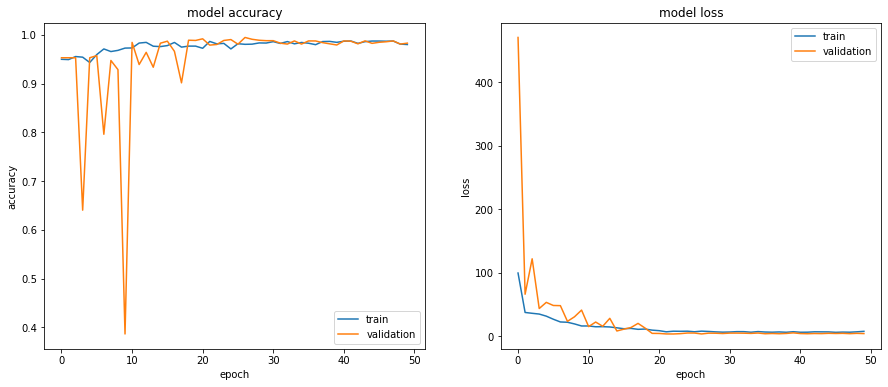

In [30]:

plt.figure(figsize=(15, 6))

print(history.history.keys())
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.show()

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.suptitle("Conv + LSTM + Dense Head")
plt.show()


In [19]:
test_loss,test_accuracy = pp_model.evaluate(ds_test)


42/42 [==============================] - 1s 35ms/step - loss: 5.2865 - accuracy: 0.9857


In [6]:
pp_model.save("ppmodel_{}.h5".format(test_loss),save_format='h5')
#pp_model=tf.keras.models.load_model('/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/iter_create_np_fromrbag/ppmodel_5.286526679992676.h5',compile=False)

pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')
test_loss,test_accuracy = pp_model.evaluate(ds_test)


42/42 [==============================] - 1s 34ms/step - loss: 4.8334 - accuracy: 0.9901


In [5]:
predictions = pp_model.predict(ds_test)


In [6]:
#example["grid_map"],example["grid_org_res"],example["left_bnd"],
#            example["right_bnd"],example["car_odo"],example["init_path"]
np.shape(predictions)

(1329, 25, 2)

In [7]:

def get_test_ds_size(ds_test):
    num_of_samples=0
    for input_batch, output_batch in ds_test:
        for i in range(0,len(input_batch[0].numpy())):
            num_of_samples+=1
    return num_of_samples

def get_np_test_ds(ds_test):

    samples = get_test_ds_size(ds_test)
    np_tst_gridmap = np.zeros(shape=(samples,1536,1536))
    np_tst_grid_org_res = np.zeros(shape=(samples,3))
    np_tst_left_bnd = np.zeros(shape=(samples,25,2))
    np_tst_right_bnd = np.zeros(shape=(samples,25,2))
    np_tst_car_odo = np.zeros(shape=(samples,3))
    np_tst_init_path = np.zeros(shape=(samples,25,2))
    np_tst_opt_path = np.zeros(shape=(samples,25,2))

    for input_batch, output_batch in ds_test:
        for i in range(0,len(input_batch[0].numpy())):
            np_tst_gridmap[i]=input_batch[0][i].numpy()
            np_tst_grid_org_res[i] = input_batch[1][i].numpy()
            np_tst_left_bnd[i] = input_batch[2][i].numpy()
            np_tst_right_bnd[i] = input_batch[3][i].numpy()
            np_tst_car_odo[i] = input_batch[4][i].numpy()
            np_tst_init_path[i] = input_batch[5][i].numpy()
            np_tst_opt_path[i] = output_batch[i].numpy()
            
    return np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,np_tst_opt_path
    

In [8]:
np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,np_tst_opt_path =get_np_test_ds(ds_test)



In [23]:
def plot_scene(features):    
    grid_map = features["grid_map"]
    grid_org = features["grid_org_res"]
    left_bnd = features["left_bnd"]
    right_bnd = features["right_bnd"]
    init_path = features["init_path"]
    opt_path = features["opt_path"]
    car_odo = features["car_odo"]

    predict_path = features["predictions"]

    #print(type(grid_map))
    fig=plt.figure(figsize=(7, 7))
    ax=fig.add_subplot(1,1,1)

    res = grid_org[2]
    ax.plot((left_bnd[:,0]-grid_org[0])/res,(left_bnd[:,1]-grid_org[1])/res,'-.', color='magenta',markersize=0.5, linewidth=0.5)

    ax.plot((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res,'o-', color='lawngreen',markersize=1, linewidth=1)
    ax.plot((opt_path[:,0]-grid_org[0])/res,(opt_path[:,1]-grid_org[1])/res,'--', color='yellow',markersize=1, linewidth=1)

    ax.plot((predict_path[:,0]-grid_org[0])/res,(predict_path[:,1]-grid_org[1])/res,'-o', color='brown',markersize=2, linewidth=1)

    ax.plot((right_bnd[:,0]-grid_org[0])/res,(right_bnd[:,1]-grid_org[1])/res, '-.',color='magenta',markersize=0.5, linewidth=0.5)


    ax.plot((car_odo[0]-grid_org[0])/res,(car_odo[1]-grid_org[1])/res,'r*', color = 'red',markersize=8)


    ax.legend(['Left bound', 'gt_init_path', 'gt_opt_path','predicted_path','right bound', 'car_centre'], loc='lower left')

    ax.imshow(grid_map,origin="lower")

    return ax,fig

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cc04adc70>,
 <Figure size 504x504 with 1 Axes>)

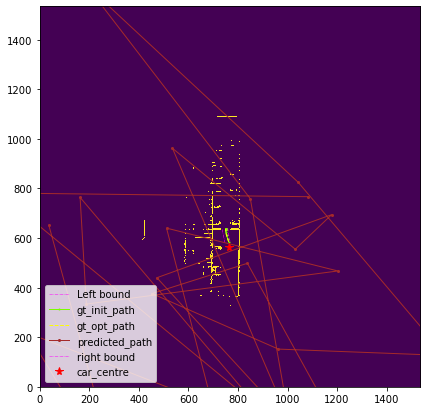

In [24]:
test_idx=10
test_data={}
test_data["grid_map"]= np_tst_gridmap[test_idx]
test_data["grid_org_res"]=np_tst_grid_org_res[test_idx]
test_data["left_bnd"]=np_tst_left_bnd[test_idx]
test_data["right_bnd"]=np_tst_right_bnd[test_idx]
test_data["car_odo"]=np_tst_car_odo[test_idx]
test_data["init_path"]=np_tst_init_path[test_idx]
test_data["opt_path"]=np_tst_opt_path[test_idx]
test_data["predictions"] = predictions[test_idx]


plot_scene(test_data)

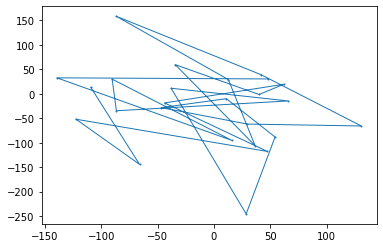

In [25]:
plt.plot(predictions[test_idx][:,0],predictions[test_idx][:,1],'-o',markersize=1, linewidth=1)